In [46]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sea
import copy
import emoji
import time as time
from nltk.tokenize import TweetTokenizer
from nltk.corpus import sentiwordnet as swm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from afinn import Afinn
from statistics import mode

In [47]:
data = pd.read_csv('InitialData.csv',header = None)
data = data.iloc[:,3]

In [3]:
print(data.shape)

(1701,)


# Data Preprocessing

### Removing handle name and hashtags

In [4]:
def dataCleaning(data):
    # reger for handle, for RT and for URls
    regexes = ['@[A-Z0-9a-z_:]+','^[RT]+','https?://[A-Za-z0-9./]+','(#\w+)','[!,)(.:*“”""+_’\'?\-]+']
    for regex in regexes:
        data = data.replace(to_replace =regex, value = '', regex = True)
        data = data.str.strip()
        data = data.str.lower()
    return data

In [5]:
data = dataCleaning(data)

In [6]:
data.tail(10)

1691    just watched  movie  your performance was awes...
1692    as much as you cant believe that sundarc direc...
1693    my rating 35/5 the title of the movie is well ...
1694    producers should learn that no point of spendi...
1695    producers should learn that no point of spendi...
1696    sans the love track and songs  this movie has ...
1697    tamil  2/ 5  a plot that is enough to make a n...
1698    watched vishals     how much would you rate th...
1699    watched vijay sethupathis     how much would y...
1700    tamil  2/ 5  a typical commercial flick with a...
Name: 3, dtype: object

### Encode tweets so as to simplify the Emojis

In [7]:
def encodeString(tweets):
    return tweets.encode('ascii', 'ignore').decode('ascii')

In [8]:
data = data.apply(emoji.demojize)

In [9]:
data[25]

'i watched the  movie :film_frames: and used my  and  apps because movie :film_projector: theaters :performing_arts: dont have pause buttons :radio_button::two_men_holding_hands::two_men_holding_hands:1/2 of 5:two_men_holding_hands:'

In [10]:
data = data.replace(to_replace ='[_:]+', value = ' ', regex = True)

In [11]:
data.iloc[25]

'i watched the  movie  film frames  and used my  and  apps because movie  film projector  theaters  performing arts  dont have pause buttons  radio button two men holding hands two men holding hands 1/2 of 5 two men holding hands '

### Removing dublicate rows

In [12]:
def removeDublicate(data):
    print(data.shape[0])
    dublicateRows=data.duplicated().tolist()
    if len(dublicateRows) > 0:
        print("Completly Dublicate rows",dublicateRows.count(True))
    dublicateRows=data.iloc[:].duplicated().tolist()
    if len(dublicateRows) > 0:
        print("Dublicate Tweets",dublicateRows.count(True))
    data=data.iloc[:].drop_duplicates()
    return data;

In [13]:
data = removeDublicate(data)
print(data.shape)

1701
Completly Dublicate rows 34
Dublicate Tweets 34
(1667,)


In [14]:
# Remove word which has length less than 3
data = data.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [15]:
data.tail(20)

1679    this woman cinema asked what going when said l...
1680    give credit actually managed make michael pear...
1681    went there sudden watching emma thompson 1999 ...
1682    know coming tonight candidly 1976 version henr...
1683    biggest reason wont seeing that pens classic t...
1684               giving modern memphis belle vibes here
1685    lieutenant commander wade mcclusky 2november 3...
1686    opens today most turning points history what g...
1687    sick that psyched film about terrible event wh...
1688                                 1942 roland emmerich
1689    movie pretty good feel good recounting strife ...
1691    just watched movie your performance awesome na...
1692    much cant believe that sundarc directed arunac...
1693    rating 35/5 title movie well suited script act...
1694    producers should learn that point spending muc...
1696    sans love track songs this movie some amazing ...
1697    tamil plot that enough make neat racy action f...
1698    watche

### Tokennization and POS tagging

In [16]:
def convertToPosTag(tokens):
    tagged_sent = nltk.pos_tag(tokens)
    store_it = [(word, nltk.map_tag('en-ptb', 'universal', tag)) for word, tag in tagged_sent] 
    return store_it

In [17]:
tt = TweetTokenizer()
tokenizedTweets = data.apply(tt.tokenize)
POStaggedLabel = tokenizedTweets.apply(convertToPosTag)
POStaggedLabel[0]

[('amazing', 'ADJ'),
 ('performance', 'NOUN'),
 ('entire', 'ADJ'),
 ('crew', 'NOUN'),
 ('take', 'VERB'),
 ('loved', 'VERB'),
 ('every', 'DET'),
 ('your', 'PRON'),
 ('performance', 'NOUN')]

In [18]:
POStaggedLabel[25]

[('watched', 'ADJ'),
 ('movie', 'NOUN'),
 ('film', 'NOUN'),
 ('frames', 'NOUN'),
 ('used', 'VERB'),
 ('apps', 'ADV'),
 ('because', 'ADP'),
 ('movie', 'NOUN'),
 ('film', 'NOUN'),
 ('projector', 'NOUN'),
 ('theaters', 'NOUN'),
 ('performing', 'VERB'),
 ('arts', 'NOUN'),
 ('dont', 'NOUN'),
 ('have', 'VERB'),
 ('pause', 'VERB'),
 ('buttons', 'NOUN'),
 ('radio', 'VERB'),
 ('button', 'NOUN'),
 ('holding', 'VERB'),
 ('hands', 'NOUN'),
 ('holding', 'VERB'),
 ('hands', 'NOUN'),
 ('holding', 'VERB'),
 ('hands', 'NOUN')]

### Removing STOP word and lemmatizing the tweets

In [36]:
def ConvertToSimplerPosTag(tag):
    if(tag=='NOUN'):
        tag='n'
    elif(tag=='VERB'):
        tag='v'
    elif(tag=='ADJ'):
        tag='a'
    elif(tag=='ADV'):
        tag = 'r'
    else:
        tag='nothing'
    return tag 

In [37]:
stop_words = stopwords.words('english')
pstem = PorterStemmer()
lem = WordNetLemmatizer()

In [38]:
def removeStopWord(row):
    filteredList = [(i,j) for i,j in row if i not in stop_words ]
    return filteredList

In [39]:
noStopWordList =  POStaggedLabel.apply(removeStopWord)

In [42]:
def lemmatize(row):
    lemmatizeWord = [lem.lemmatize(w) for w,tag in row] #,pos= ConvertToSimplerPosTag(tag)
    return [pstem.stem(i) for i in lemmatizeWord]

In [43]:
lemmatizedDF = noStopWordList.apply(lemmatize)

In [44]:
lemmatizedDF.head()

0    [amaz, perform, entir, crew, take, love, everi...
1                    [came, incred, truli, amaz, work]
2    [seem, bore, predict, stori, told, realli, ban...
3    [watch, look, isnt, wave, cinema, pleas, ceas,...
4    [good, movi, fail, person, opinion, hardli, pr...
Name: 3, dtype: object

# Ground Truth Labling

In [48]:
modelType = ["Text Blob","SentiWordNet","Afinn",'Combined']
negative = []
neutral = []
positive =[]

### Labeling the tweets with TextBlob

In [49]:
def getLabels(row):
    polarity =  TextBlob(" ".join(row)).sentiment.polarity
    return 1 if polarity > 0 else 0 if polarity == 0 else -1 

In [50]:
SetimentLabel = tokenizedTweets.apply(getLabels)

In [51]:
valueCountSentiment = SetimentLabel.value_counts()

In [52]:
print(valueCountSentiment.sort_index())
count = list(valueCountSentiment.sort_index())

-1     259
 0     168
 1    1240
Name: 3, dtype: int64


In [53]:
print(count)
negative.append(count[0])
neutral.append(count[1])
positive.append(count[2])

[259, 168, 1240]


### Labeling the tweets with sentiwordnet

In [54]:
def ConvertToSimplerPosTag(tag):
    if(tag=='NOUN'):
        tag='n'
    elif(tag=='VERB'):
        tag='v'
    elif(tag=='ADJ'):
        tag='a'
    elif(tag=='ADV'):
        tag = 'r'
    else:
        tag='nothing'
    return tag 

In [55]:
def getSentimentOfWorld(row):
    positiveScore = []
    negativeScore = []
    for word ,tag in row:
        try:
            tag = ConvertToSimplerPosTag(tag)      
            if(tag!='nothing'):
                concat =  word+'.'+ tag+ '.01'
                positiveScore.append(swm.senti_synset(concat).pos_score())
                negativeScore.append(swm.senti_synset(concat).neg_score())
        except Exception as e:
            #print (e)
            #print("An exception occurred")
            pstem = PorterStemmer()
            lem = WordNetLemmatizer()
            word = lem.lemmatize(word)
            word = pstem.stem(word)
            concat =  word+'.'+ tag+ '.01'
            try:
                positiveScore.append(swm.senti_synset(concat).pos_score())
                negativeScore.append(swm.senti_synset(concat).neg_score())
            except Exception as ex:
                pass
                #print("Nested error.")
            #continue
    postiveScoreTotal = np.sum(positiveScore)
    negativeScoreTotal = np.sum(negativeScore)
    if(postiveScoreTotal > negativeScoreTotal) : 
        return 1
    elif (postiveScoreTotal < negativeScoreTotal) : 
        return -1
    else:
        return 0

In [56]:
sentiDF  = POStaggedLabel.apply(getSentimentOfWorld)

In [57]:
count = list(sentiDF.value_counts().sort_index())

In [58]:
print(count)
negative.append(count[0])
neutral.append(count[1])
positive.append(count[2])

[350, 155, 1162]


### Labeling Tweets with AFINN 

In [59]:
def getSentimentAfinn(row):
    af = Afinn()
    polarity = af.score(" ".join(row))
    return 1 if polarity > 0 else 0 if polarity == 0 else -1

In [60]:
AfinnLabel = tokenizedTweets.apply(getSentimentAfinn)

In [61]:
count=list(AfinnLabel.value_counts().sort_values())
print(count)
negative.append(count[0])
neutral.append(count[1])
positive.append(count[2])

[219, 341, 1107]


# Combing the result of All the sentiment analysor above

In [62]:
def assignLabel(row):
    notAssigned = []
    try:
        return mode(row)
    except Exception as ex: 
        return row[1]

In [63]:
combineLabel =  pd.concat([SetimentLabel ,sentiDF, AfinnLabel ] , axis = 1,sort=False)
combineLabel.columns = [1,2,3]

In [64]:
yLabel= combineLabel.apply(assignLabel,axis =1)


In [65]:
count = list(yLabel.value_counts().sort_values())
negative.append(count[0])
neutral.append(count[1])
positive.append(count[2])

In [66]:
print(len(yLabel))
print(len(lemmatizedDF))

1667
1667


In [67]:
def autolabel(ax,rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = float("{0:.2f}".format(rect.get_height()))
        height = int(height)
        ax.annotate('{}'.format(height),xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

In [96]:
def plotComparisionGraph(modelType,negative,neutral,positive,endValue):
    
    print(len(negative))
    ind = np.array([i for i in range(3,endValue,3)])  # the x locations for the groups
    print(ind)
    width = 0.65  # the width of the bars
    
    fig, ax = plt.subplots(figsize = (6,5) )
    rects1 = ax.bar(ind- width , negative, width,label='Accuracy')  #yerr=men_std
    rects2 = ax.bar(ind, neutral, width, label='Precision') #yerr=women_std,
    rects3 = ax.bar(ind+ width, positive, width, label='Recall') #yerr=women_std,
    #rects4 = ax.bar(ind+ (1.5*width), f1ScoreList, width, label='F1-Score') #yerr=women_std,
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    #ax.set_title('Count comparision between differnet Lexicon Model')
    ax.set_xticks(ind)
    ax.set_xticklabels(modelType)
    ax.legend(loc='upper center', bbox_to_anchor=(0.90, 0.8), ncol=1) #shadow=True
        
    autolabel(ax,rects1, "center")
    autolabel(ax,rects2, "center")
    autolabel(ax,rects3, "center")
    #autolabel(ax,rects4, "center")    
    
    
    #fig.tight_layout()
    plt.show()

4
[ 3  6  9 12]


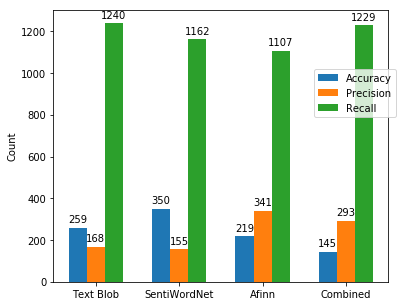

In [97]:
plotComparisionGraph(modelType,negative,neutral,positive,13)

### Visualize with the help of WorldCloud

In [60]:
def plotWorldCould(Flattenlist,label):
    plt.rcParams['figure.figsize']=(10.0,8.0)    
    plt.rcParams['font.size']=10 
    stopwords = set(STOPWORDS)
    text = " ".join(tweet for tweet in [" ".join(i) for i in Flattenlist])
    #print(text)
    print ("There are {} words in the combination of all tweets.".format(len(text)))

    wordcloud = WordCloud(
                              background_color='black',
                              stopwords=stopwords,
                              max_words=250,
                              max_font_size=50,
                              width=500, 
                              height=300,
                              random_state=42
                             ).generate(str(text))

    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(label)
    plt.show()
#fig.savefig("word1.png", dpi=1400)

In [61]:
# seperate the positive and negative data
#yLabel = SetimentLabel.to_numpy()

In [62]:
def visualizedWordCloud(lemmatizedDF,yLabel):
    # Ploting Tweets
    pos = np.where(yLabel == 0)[0]
    print(len(pos))
    neutralTweets = lemmatizedDF.iloc[pos]
    plotWorldCould(neutralTweets,"Neutral")
    
    #Ploting Positive tweets
    pos = np.where(yLabel == 1)[0]
    print(len(pos))
    print(len(lemmatizedDF))
    positiveTweets = lemmatizedDF.iloc[pos]
    plotWorldCould(positiveTweets,"Positive Word")
    
    #Ploting negative 
    pos = np.where(yLabel == -1)[0]
    print(len(pos))
    negativeTweets = lemmatizedDF.iloc[pos]
    plotWorldCould(negativeTweets,"Negative Word")

145
There are 7800 words in the combination of all tweets.


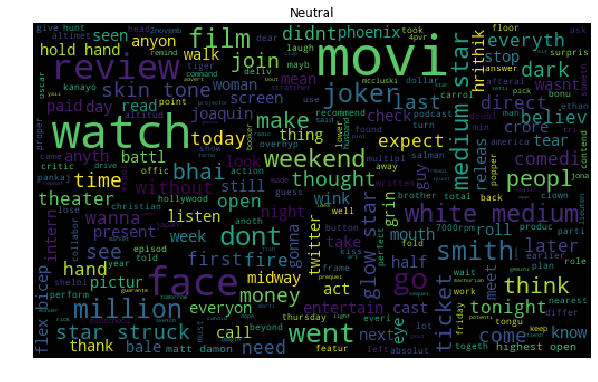

1229
1667
There are 127430 words in the combination of all tweets.


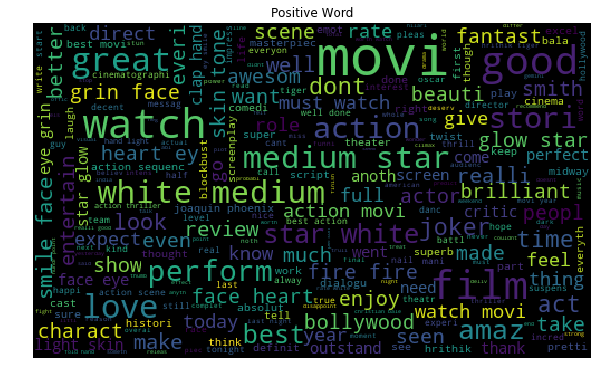

293
There are 29009 words in the combination of all tweets.


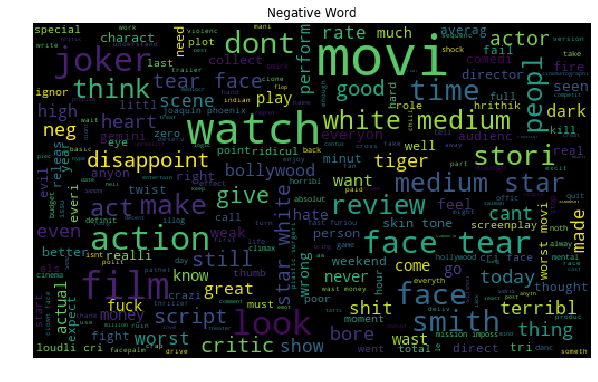

In [63]:
visualizedWordCloud(lemmatizedDF,yLabel)

# Removing Common words from the tweets

In [64]:
def removeWords(row):
    unwantedWord =['watch','film','movi','review']
    row = [i for i in row if i not in unwantedWord]
    return row

In [65]:
lemmatizedDF = lemmatizedDF.apply(removeWords)

145
There are 7230 words in the combination of all tweets.


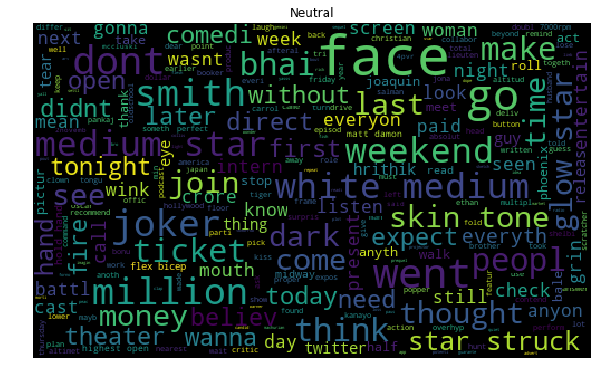

1229
1667
There are 119890 words in the combination of all tweets.


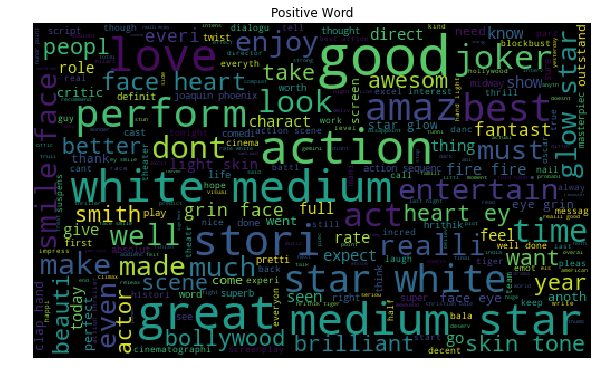

293
There are 27427 words in the combination of all tweets.


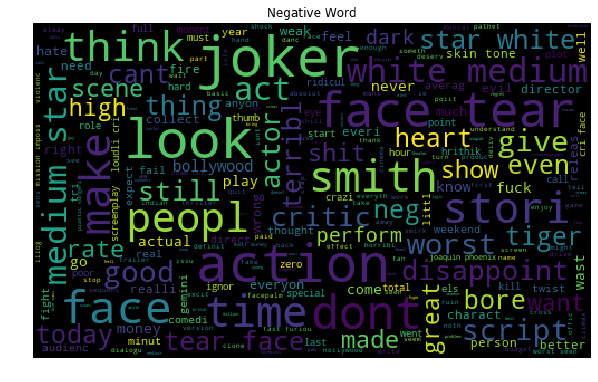

In [66]:
#Re-visualized
visualizedWordCloud(lemmatizedDF,yLabel)

# Saving PrepossedDF to CSV 

In [73]:
#lemmatizedDF
joinedTweet = lemmatizedDF.apply(lambda x: str(" ".join(x)))

In [74]:
data = pd.concat([joinedTweet,yLabel],axis = 1 )
data.columns = ['tweets','label']

In [75]:
data.to_csv('PrepeocessedFile.csv', index=False)